#      Main Code for extracting data from the ECI website

In [9]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd
import json
import os

def get_election_summary_results():
    summary_url = 'https://results.eci.gov.in/PcResultGenJune2024/index.htm'
    res = req.get(summary_url)
    res.raise_for_status()
    
    soup = BeautifulSoup(res.text, 'html.parser')
    table = soup.find('table', {'class': 'table'})
    
    if table:
        headers = [th.text.strip() for th in table.find_all('th')]
        rows = table.find_all('tr')
        summary_results = []

        for row in rows:
            cells = row.find_all('td')
            if cells:
                result_data = [cell.text.strip() for cell in cells]
                summary_results.append(result_data)
        
        return headers[0:4], summary_results
    else:
        print("Unable to retrieve election summary !!")
        return None, None

def get_statewise_results(state_code):
    state_result_url = f'https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-{state_code}.htm'
    res = req.get(state_result_url)
    if res.status_code != 200:
        print(f'Failed to retrieve data for state code {state_code}. Status code: {res.status_code}')
        return None, None, None
    
    soup = BeautifulSoup(res.text, 'html.parser')
    table = soup.find('table', {'class': 'table'})
    
    if table:
        state_name = soup.find('div', {'class': 'page-title'}).text.strip().split("2024")[1].split("(")[0]
        headers = [th.text.strip() for th in table.find_all('th')]
        rows = table.find_all('tr')
        state_results = []

        for row in rows:
            cells = row.find_all('td')
            if cells:
                result_data = [cell.text.strip() for cell in cells]
                state_results.append(result_data)
        
        return state_name, headers[0:4], state_results
    else:
        print(f'Data not found for state code: {state_code}')
        return None, None, None

def save_to_json(data, summary_data, file):
    result_data = {'states': {}}
    if summary_data:
        summary_headers, summary_results = summary_data
        result_data['summary'] = {'headers': summary_headers, 'results': summary_results}
    
    for state_code, (state_name, headers, results) in data.items():
        result_data['states'][state_code] = {
            'state_name': state_name,
            'headers': headers,
            'results': results
        }
    
    with open(file, 'w') as f:
        json.dump(result_data, f, indent=4)

def main():
    states_codes = ["S0" + str(state) if state < 10 else "S" + str(state) for state in range(1, 29)]
    ut_codes = ["U0" + str(ut) for ut in range(1, 9)]
    state_codes = states_codes + ut_codes
    all_results = {}

    summary_headers, summary_results = get_election_summary_results()

    for state_code in state_codes:
        state_name, headers, results = get_statewise_results(state_code)
        if headers and results:
            all_results[state_code] = (state_name, headers, results)
    
    save_to_json(all_results, (summary_headers, summary_results), 'general_election_results.json')

if __name__ == '__main__':
    main()


Failed to retrieve data for state code S09. Status code: 404
Failed to retrieve data for state code U04. Status code: 404


##  

## Visualisation of the data

In [205]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [161]:
# Load JSON data into a DataFrame
election_data = pd.read_json('general_election_results.json')

In [163]:
election_data_df = pd.DataFrame(election_data.summary.results[0:], columns=election_data.summary.headers)

In [165]:
election_data_df1 = election_data_df.copy()

In [25]:
election_data_df1.dtypes

Party      object
Won        object
Leading    object
Total      object
dtype: object

In [27]:
election_data_df1.shape

(42, 4)

In [29]:
election_data_df1.head()

,Party,Won,Leading,Total
0,Bharatiya Janata Party - BJP,240,0,240
1,Indian National Congress - INC,99,0,99
2,Samajwadi Party - SP,37,0,37
3,All India Trinamool Congress - AITC,29,0,29
4,Dravida Munnetra Kazhagam - DMK,22,0,22


In [31]:
election_data_df1.tail()

,Party,Won,Leading,Total
37,Aazad Samaj Party (Kanshi Ram) - ASPKR,1,0,1
38,Apna Dal (Soneylal) - ADAL,1,0,1
39,AJSU Party - AJSUP,1,0,1
40,All India Majlis-E-Ittehadul Muslimeen - AIMIM,1,0,1
41,Independent - IND,7,0,7


In [33]:
edc_won = election_data_df1["Won"].astype('int32')

In [35]:
edc_won.head()

0    240
1     99
2     37
3     29
4     22
Name: Won, dtype: int32

In [171]:
edc_parties = election_data_df1["Party"].convert_dtypes()

In [173]:
edc_parties.head()

0           Bharatiya Janata Party - BJP
1         Indian National Congress - INC
2                   Samajwadi Party - SP
3    All India Trinamool Congress - AITC
4        Dravida Munnetra Kazhagam - DMK
Name: Party, dtype: string

#

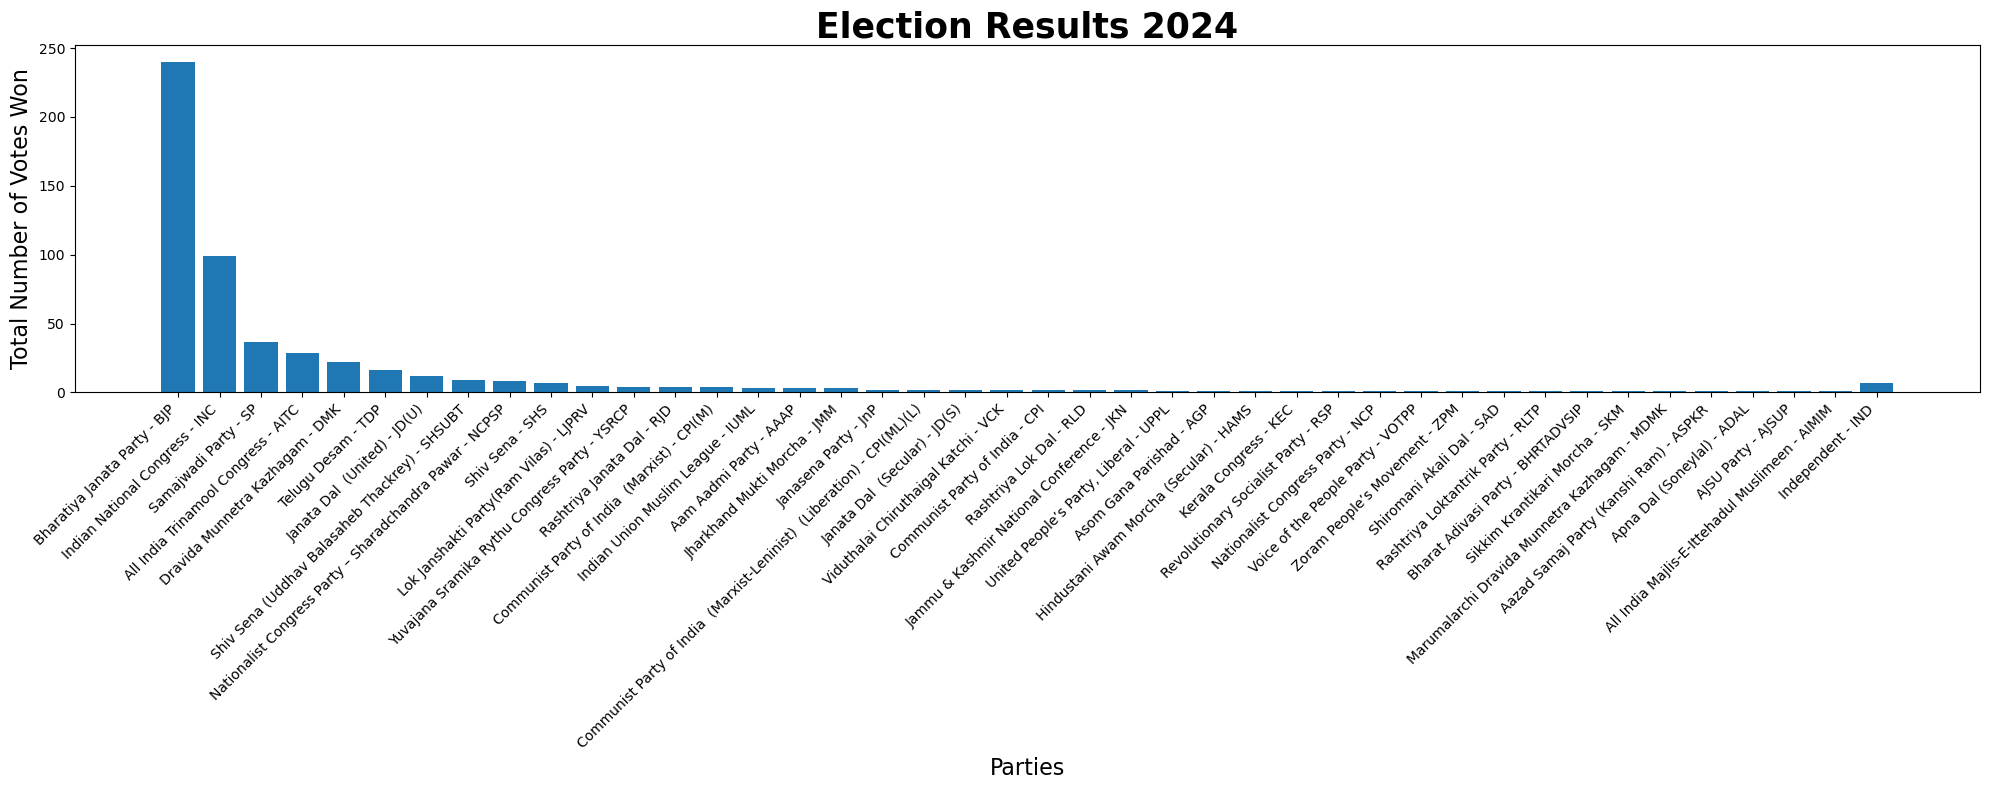

In [42]:
plt.figure(figsize=(20, 8))
plt.bar(edc_parties, edc_won)
plt.xlabel('Parties', fontsize=16)
plt.ylabel('Total Number of Votes Won', fontsize=16)
plt.title('Election Results 2024', fontsize=25, fontweight = 'bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

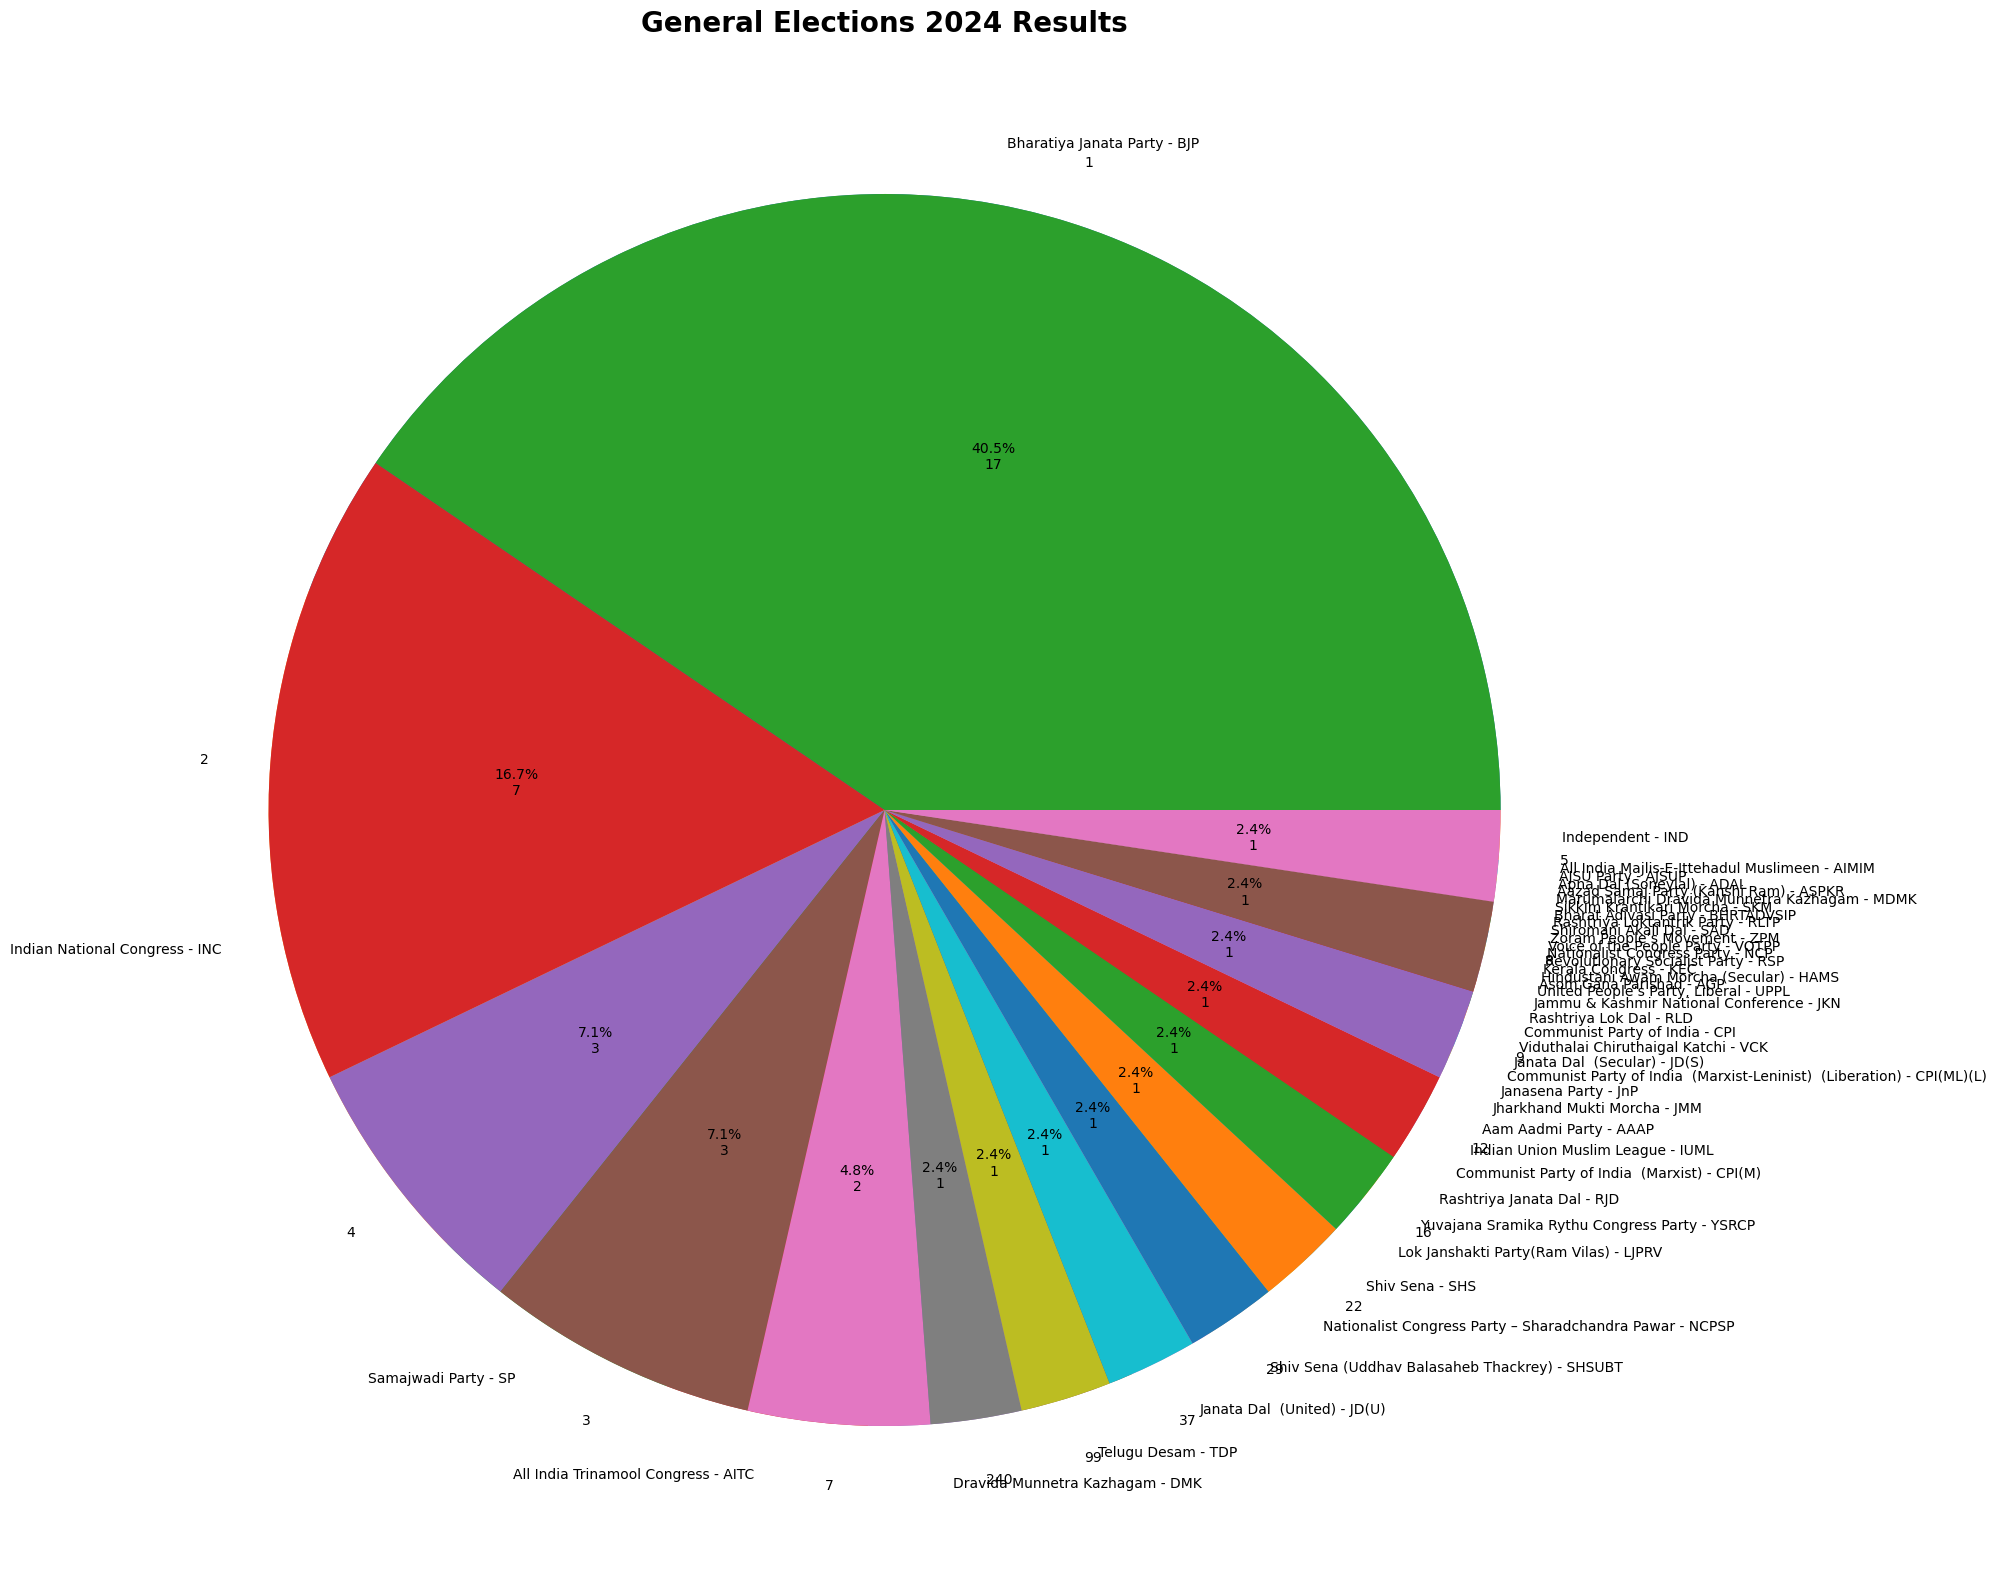

In [175]:
fig = plt.figure(figsize=(25, 20))
plt.pie(edc_won, labels = edc_parties)
plt.title("General Elections 2024 Results", fontsize = 20, fontweight = 'bold')
edc_won = election_data_df1["Won"].astype('int32')
total = edc_won.value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(edc_won.value_counts().values, labels=edc_won.value_counts().index, autopct=fmt)
plt.show()

# Inferences

* No party gained majority of 272 seats, which means that there are chances that government will form along with allies
* BJP gained the highest number of seats (240), congress gained second highest (99)
* There are more chances that BJP will form the government as it only needs 32 seats
* Overall voting results indicates that Indians still have confidence in the current government. 

#

# State Wise Result Analysis 

In [179]:
election_data1 = pd.read_json('general_election_results.json')

In [181]:
election_data1[:-2].columns

Index(['states', 'summary'], dtype='object')

In [189]:
dfs = []

for state_key, state_data in election_data1[:-2]['states'].items():
    state_name = state_data['state_name'].strip()
    
    df = pd.DataFrame(state_data['results'], columns=state_data['headers'])
    df[['Won', 'Leading', 'Total']] = df[['Won', 'Leading', 'Total']].apply(pd.to_numeric)
    df['state_name'] = state_name
    dfs.append(df)
    
final_df = pd.concat(dfs, ignore_index=True)

In [191]:
print(final_df.columns)

Index(['Party', 'Won', 'Leading', 'Total', 'state_name'], dtype='object')


/var/folders/dz/7n83w1j506z5r3z_rnyz2ndw0000gt/T/ipykernel_54430/1048079586.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(state_names, rotation=45, ha='right', fontsize=5)
/var/folders/dz/7n83w1j506z5r3z_rnyz2ndw0000gt/T/ipykernel_54430/1048079586.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(state_names, rotation=45, ha='right', fontsize=5)
/var/folders/dz/7n83w1j506z5r3z_rnyz2ndw0000gt/T/ipykernel_54430/1048079586.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(state_names, rotation=45, ha='right', fontsize=5)
/var/folders/dz/7n83w1j506z5r3z_rnyz2ndw0000gt/T/ipykernel_54430/1048079586.py:13: UserWarning: set_ticklabels() should only be used with a fi

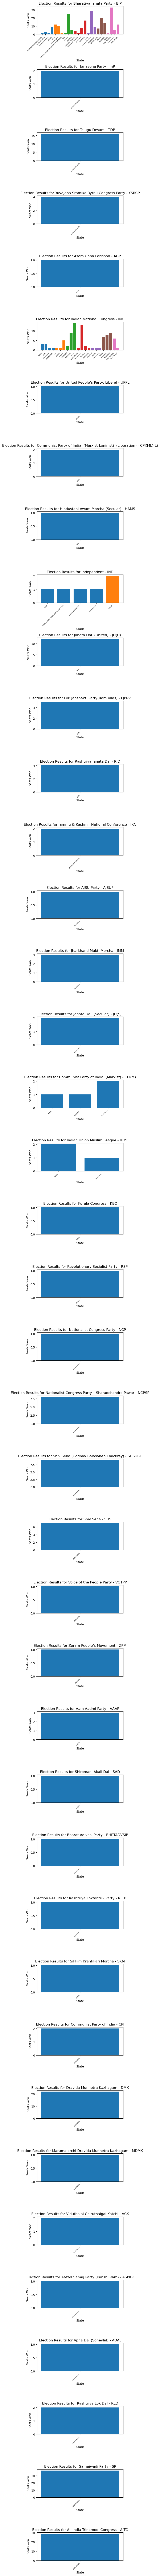

In [217]:
grouped = final_df.groupby(['state_name', 'Party']).sum().reset_index()

parties = grouped['Party'].unique()

fig, axs = plt.subplots(len(parties), 1, figsize=(5, 3 * len(parties)))
colors = plt.cm.tab10(np.linspace(0, 1, len(grouped['state_name'].unique())))
for i, party in enumerate(parties):
    party_data = grouped[grouped['Party'] == party]
    state_names = party_data['state_name']
    won_seats = party_data['Won']
    
    axs[i].bar(state_names, won_seats, label=party, color=colors)
    axs[i].set_xticklabels(state_names, rotation=45, ha='right', fontsize=5)
    axs[i].set_title(f'Election Results for {party}')
    axs[i].set_xlabel('State')
    axs[i].set_ylabel('Seats Won')

plt.tight_layout()
plt.show()

# Inference - States with best performance along with major number of seats
* BJP has won good number of seats in MP, UP, Odisha, Gujrat
* INC has won good number of seats in Maharashtra, Kerela, Karnataka, Tamil Nadu

In [243]:
grouped = final_df.groupby('state_name').filter(lambda x: len(x) == 1)

single_party_wins = single_party_wins[['Party', 'Total', 'state_name']].drop_duplicates()
print("States where only a single party has won (Columns: Party, Total, state_name):")
print(single_party_wins)

States where only a single party has won (Columns: Party, Total, state_name):
                             Party  Total                 state_name
4     Bharatiya Janata Party - BJP      2          Arunachal Pradesh
23    Bharatiya Janata Party - BJP      4           Himachal Pradesh
33    Bharatiya Janata Party - BJP     29             Madhya Pradesh
41  Indian National Congress - INC      2                    Manipur
44   Zoram People’s Movement - ZPM      1                    Mizoram
45  Indian National Congress - INC      1                   Nagaland
57  Sikkim Krantikari Morcha - SKM      1                     Sikkim
65    Bharatiya Janata Party - BJP      2                    Tripura
81    Bharatiya Janata Party - BJP      5                Uttarakhand
82    Bharatiya Janata Party - BJP      1  Andaman & Nicobar Islands
83  Indian National Congress - INC      1                 Chandigarh
86    Bharatiya Janata Party - BJP      7               NCT OF Delhi
87  Indian National Congr

# Inference - Clean wins by 2 major parties in India
* BJP had clean sweep in Arunachal Pradesh, Himachal Pradesh, Madhya Pradesh, Tripura, Uttarakhand, Andaman & Nicobar Islands, Delhi
* Congress had clean sweep in Manipur, Nagaland, Chandigarh, Lakshadweep, Puducherry
* Although we see other parties having clean sweeps along with congress in some of the states but the number of seats in these states are less as compared to win of BJP in other states. 